# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
# basic packages

import math

import numpy as np
import pandas as pd

# model prep/test packages

import re
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

# matplotlib and packages to manipulate/visualize

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# packages to create basic models

from sklearn.dummy import DummyClassifier
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import spacy

# packages to create BERT models

import torch
import transformers

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

We will take a look at our data for missing values, data types, etc.

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

There are two to four null rows, two in average_rating and two in votes. We will investigate this shortly.

In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


### Check null values

In [8]:
df_reviews[df_reviews['average_rating'].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [9]:
df_reviews[df_reviews['tconst'] == 'tt0192317']

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


Both of our missing values appear to be for this film, Mila Ass Painting. Most of the values seem to be blank - it has no genre or runtime. Since these two reviews are the only one for this movie then it might be better to simply remove these so that the null values do not complicate any data analysis.

In [10]:
df_reviews.dropna(inplace = True)

## EDA

Let's check the number of movies and reviews over years.

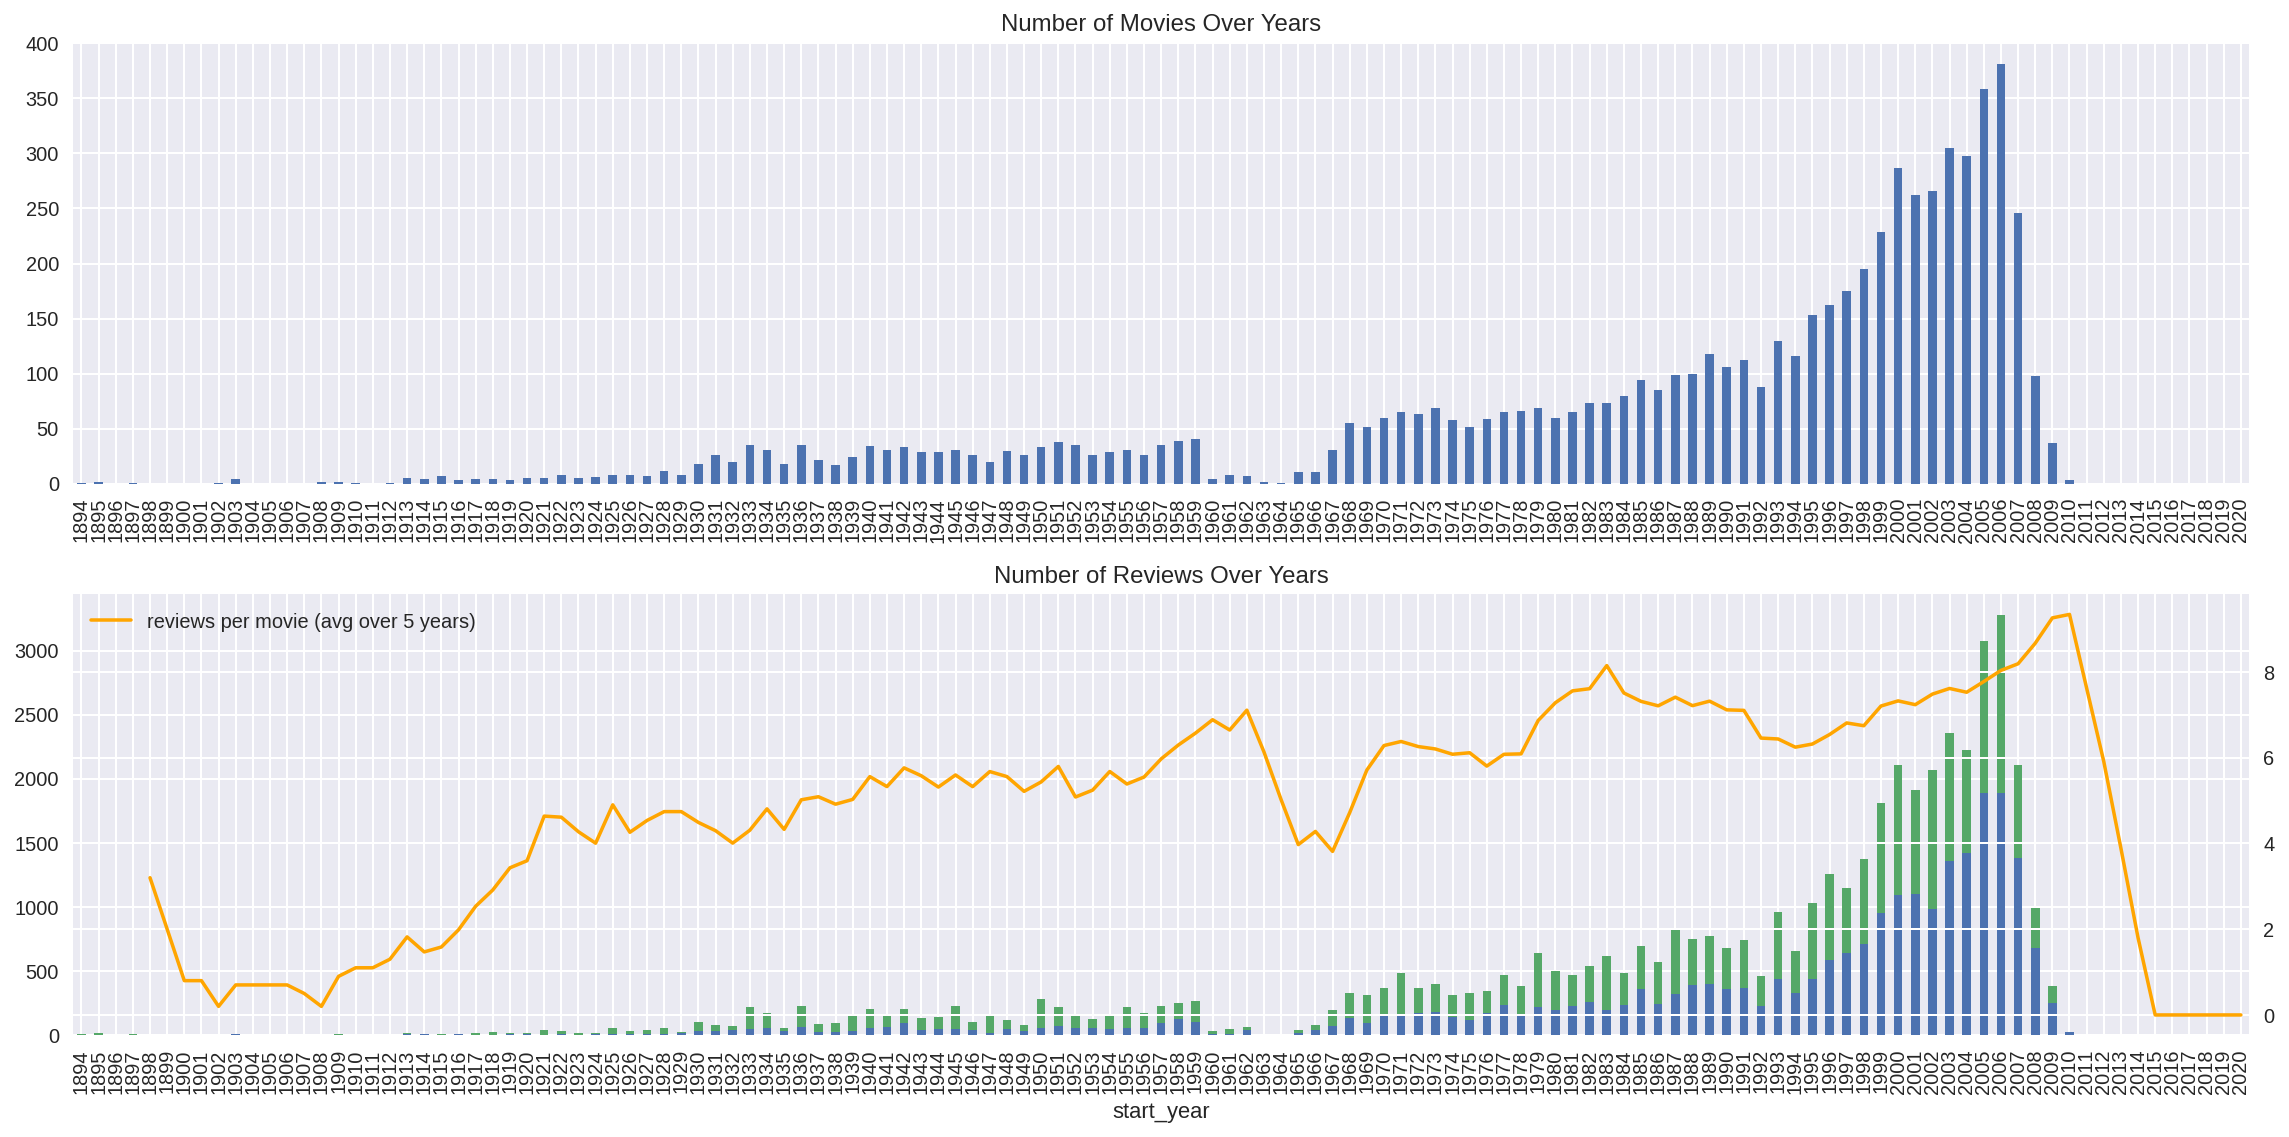

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

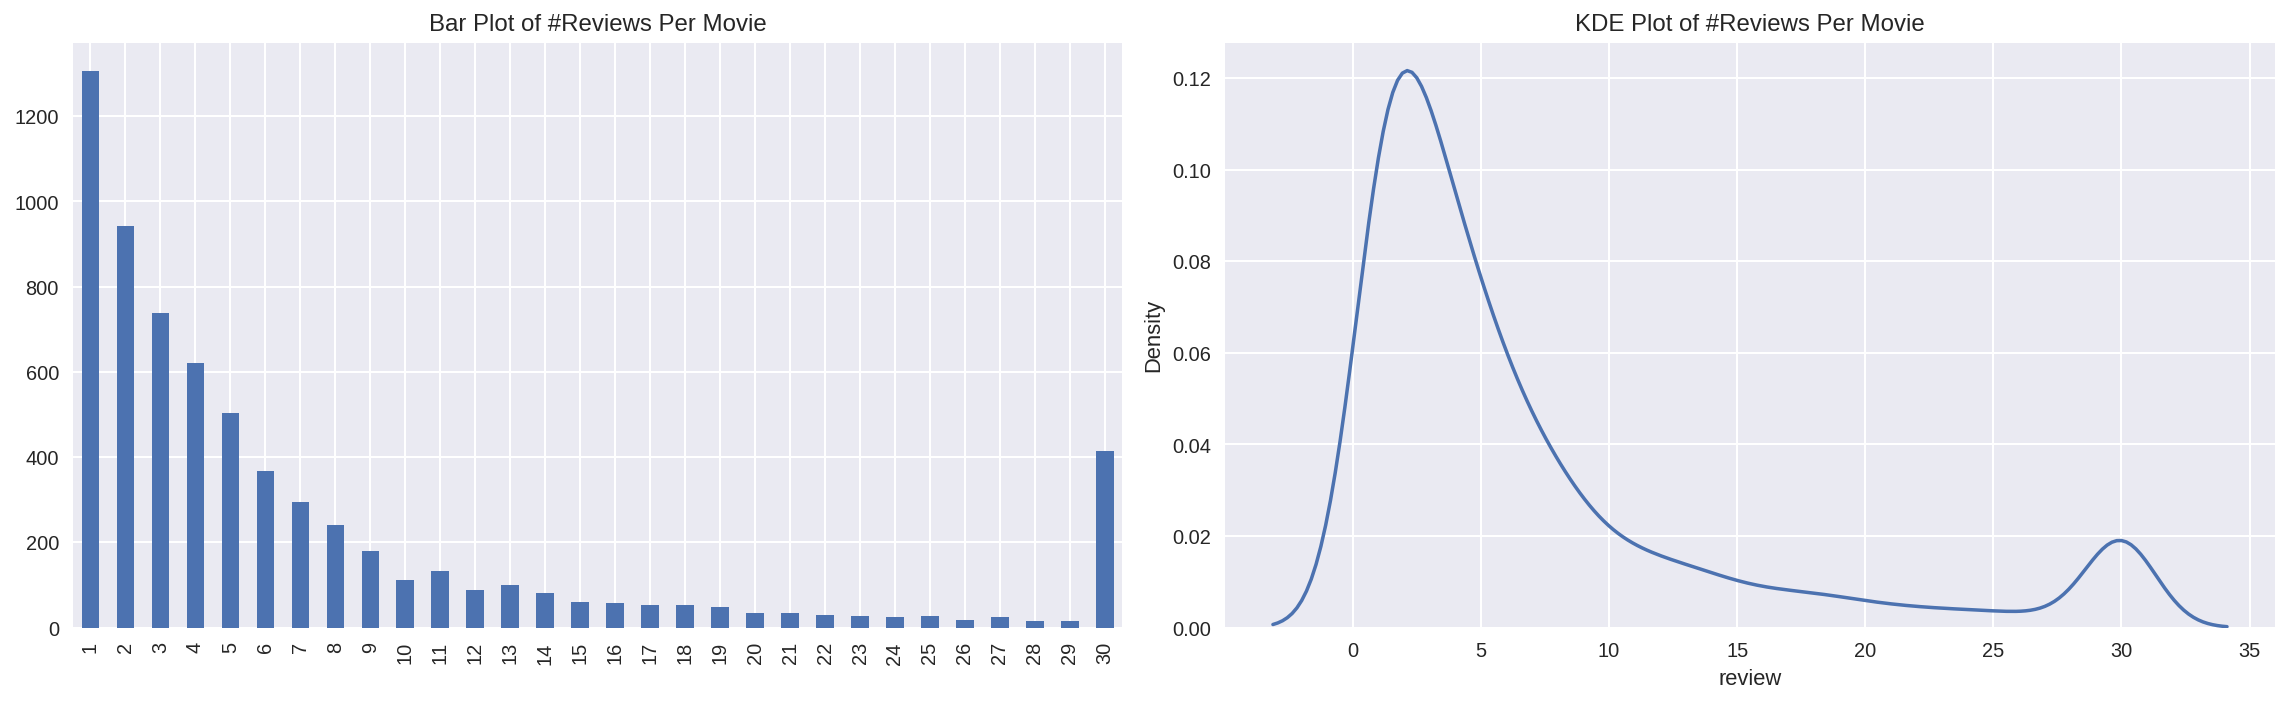

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

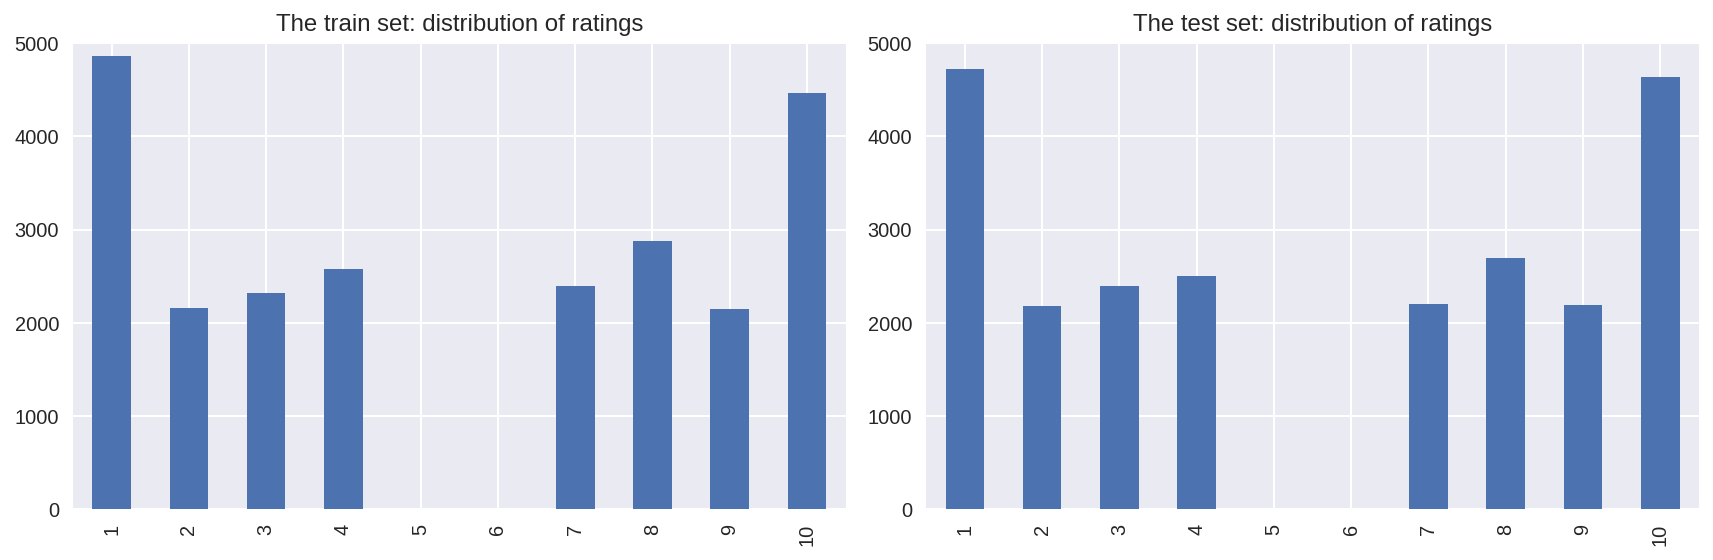

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


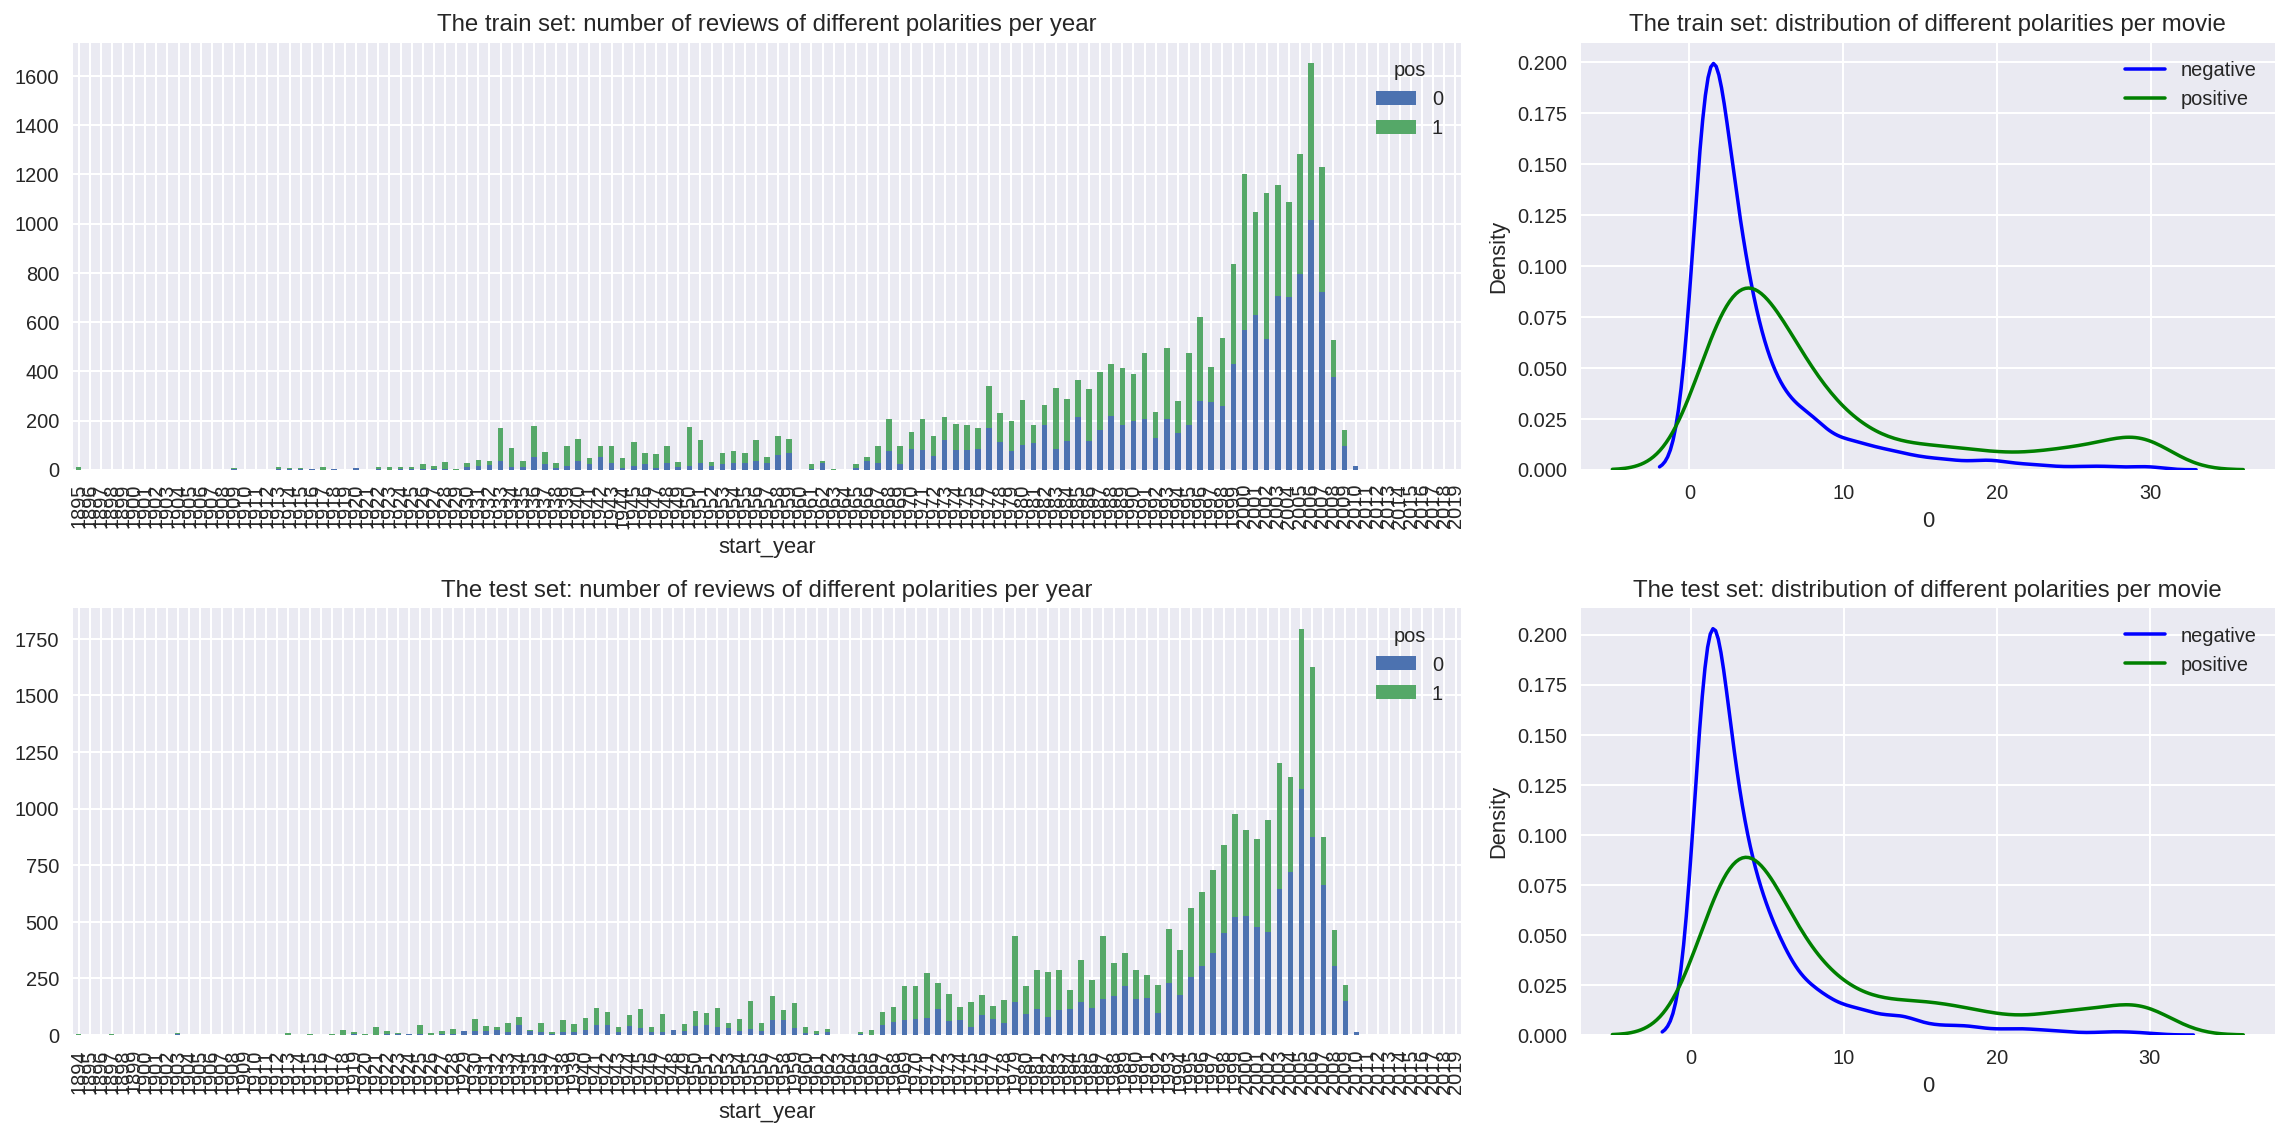

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [16]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc. Thus, we need to create a function that will convert any review into that normalized state.

In [17]:
def lower(text):
    return text.lower()

def clear_text(text):
    keep = r"[^a-z ]"
    text = re.sub(keep, " ", text)
    return " ".join(text.split())

In [18]:
df_reviews['review_norm'] = df_reviews['review'].apply(lower)

In [19]:
df_reviews['review_norm'] = df_reviews['review_norm'].apply(clear_text)

In [20]:
# testing to confirm the functions work

df_reviews['review_norm'].head(10)

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i m totally agree with garryjohal from singapo...
5    this is the first movie i ve seen from singapo...
6    yes non singaporean s can t see what s the big...
7    this true story of carlson s raiders is more o...
8    should have been titled balderdash little in t...
9    the movie gung ho the story of carlson s makin...
Name: review_norm, dtype: object

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [21]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


In [22]:
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(train_features.shape, test_features.shape)
print(train_target.shape, test_target.shape)

(23796,) (23533,)
(23796,) (23533,)


## Working with models

We will test across a few different types of models for our accuracy. We will have a dummy model that uses a constant predictor, two linear regression models using NLTK and SpaCy to see how they compare against one another, a light GBM classifier, and finally we will use a BERT model.

Because the BERT model can be rather demanding on the hardware, it will need to undergo certain limitations.

### Model 0 - Constant

In [24]:
dummy_model = DummyClassifier()
dummy_model.fit(train_features, train_target)

DummyClassifier()

In [25]:
predictions = dummy_model.predict(test_features)
print('Accuracy :', accuracy_score(test_target, predictions))

Accuracy : 0.5015510134704457


          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


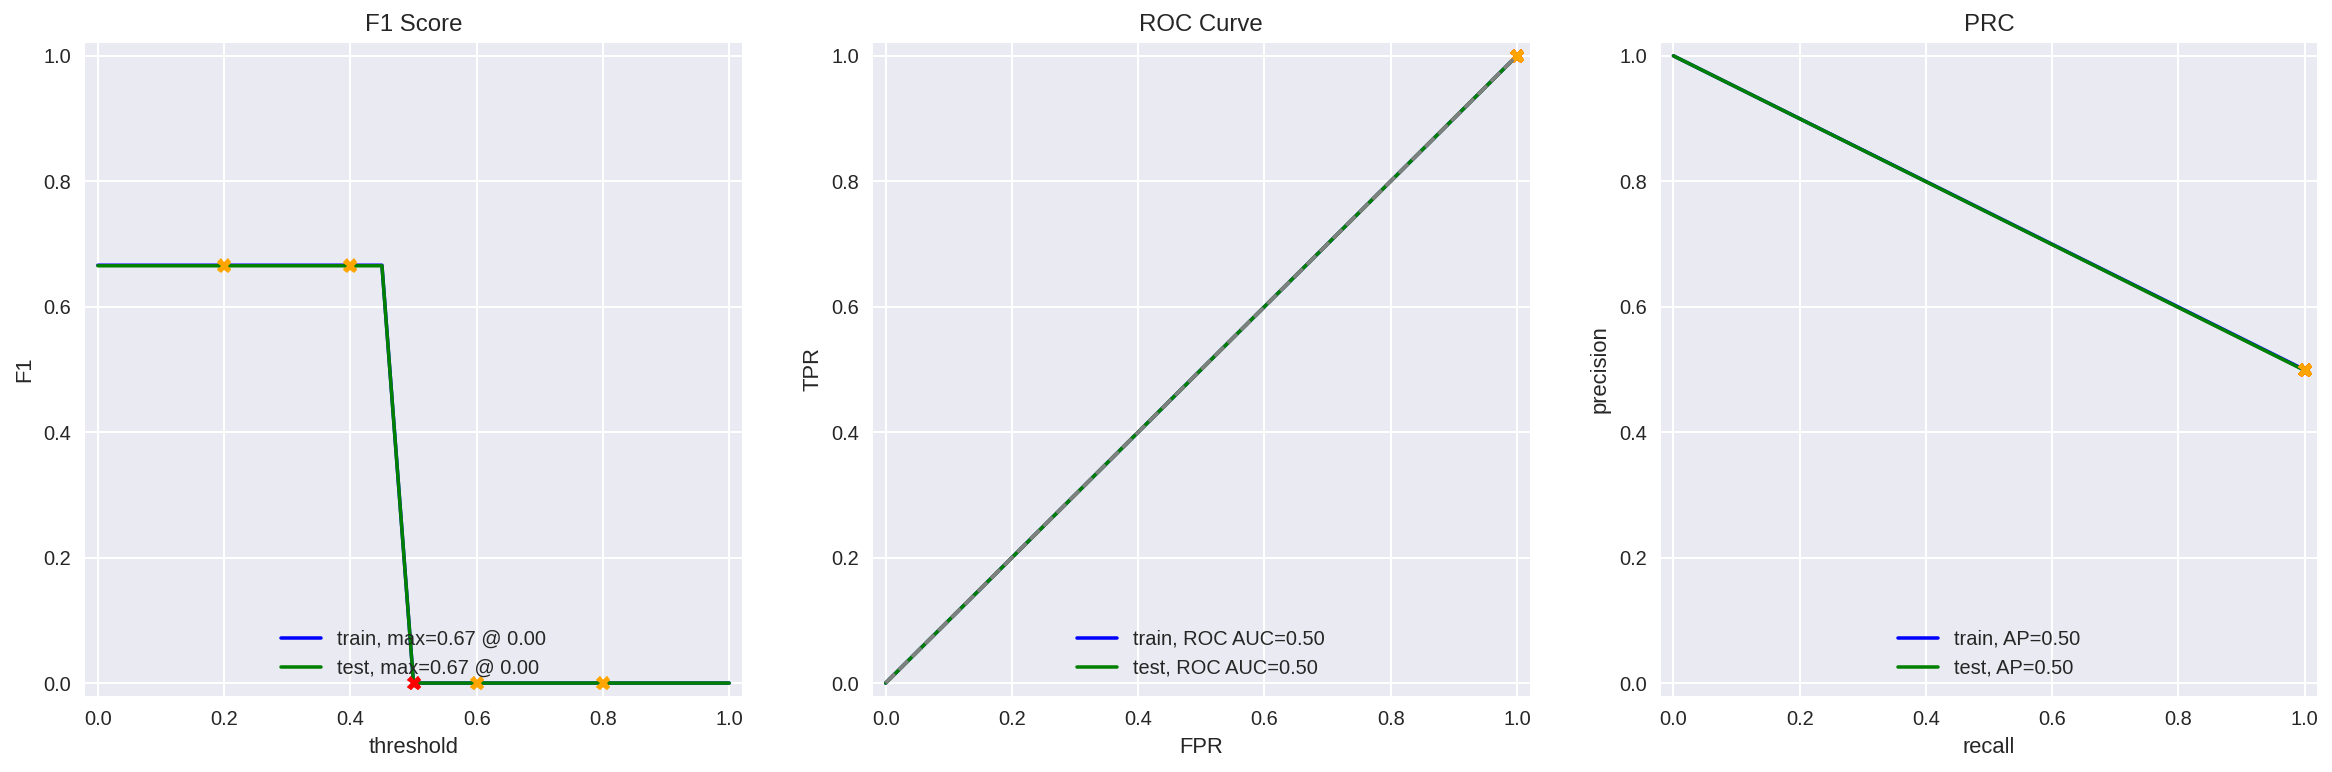

In [26]:
evaluate_model(dummy_model, train_features, train_target, test_features, test_target)

The dummy classifier has an approximate 50% accuracy, which definitely makes sense. Around half of our data is positive and the other half is negative, any sort of dummy model would be expected to have such a result.

### Model 1 - NLTK, TF-IDF and LR

In [28]:
stop_words = set(stopwords.words('english'))
count_tf_idf_1 = TfidfVectorizer(stop_words = stop_words)

nltk_train_features = count_tf_idf_1.fit_transform(train_features)
nltk_test_features = count_tf_idf_1.transform(test_features)

print("TF-IDF train size:", nltk_train_features.shape)
print("TF-IDF test size:", nltk_test_features.shape)
print("Target size", train_target.shape)

TF-IDF train size: (23796, 71531)
TF-IDF test size: (23533, 71531)
Target size (23796,)


In [29]:
model_1 = LogisticRegression(random_state = 12345)
model_1.fit(nltk_train_features, train_target)

LogisticRegression(random_state=12345)

In [30]:
predictions_1 = model_1.predict(nltk_test_features)
print('Accuracy :', accuracy_score(test_target, predictions_1))

Accuracy : 0.8830153401606256


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


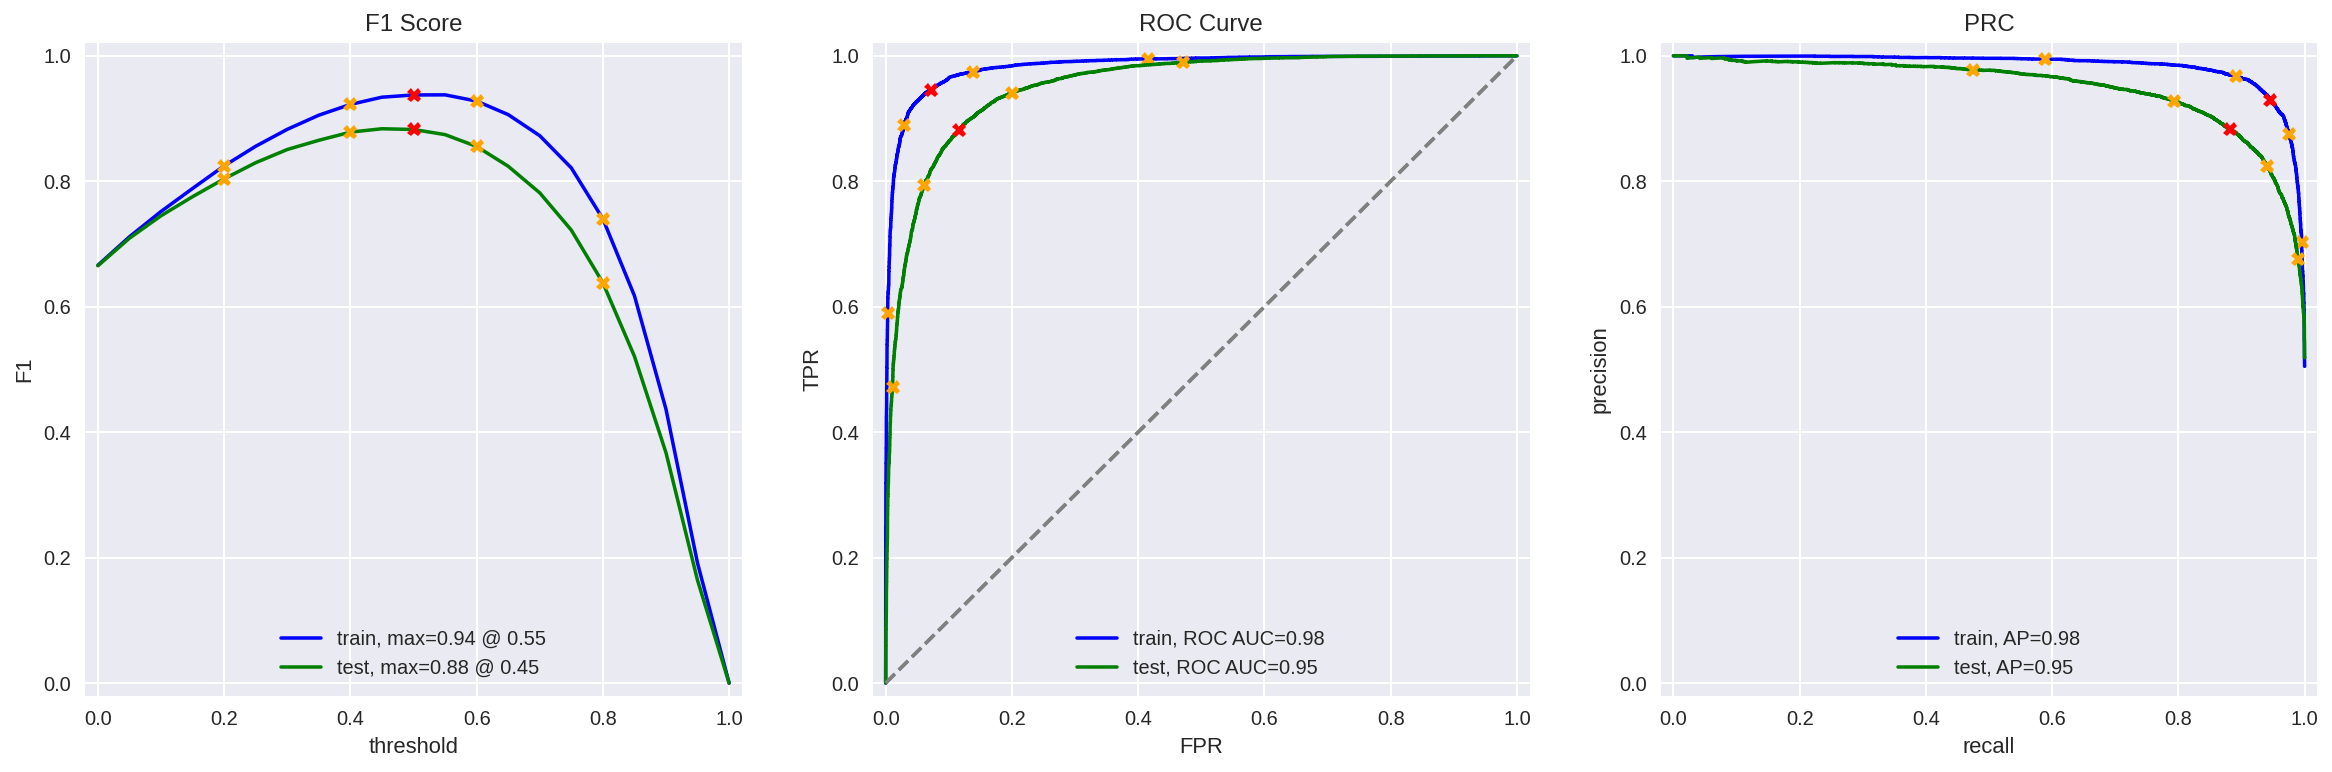

In [31]:
evaluate_model(model_1, nltk_train_features, train_target, nltk_test_features, test_target)

### Model 2 - spaCy, TF-IDF and LR

In [32]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [33]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [34]:
df_reviews['review_lemmatized'] = df_reviews['review_norm'].apply(text_preprocessing_3)

In [35]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

In [36]:
# the target variable is already set but we are using a different set of training features

spacy_train = df_reviews_train['review_lemmatized']
spacy_test = df_reviews_test['review_lemmatized']

stop_words = set(stopwords.words('english'))
count_tf_idf_2 = TfidfVectorizer(stop_words = stop_words)

spacy_train_features = count_tf_idf_2.fit_transform(spacy_train)
spacy_test_features = count_tf_idf_2.transform(spacy_test)

print("Spacy train size:", spacy_train_features.shape)
print("Spacy test size:", spacy_test_features.shape)
print("Target size", train_target.shape)

Spacy train size: (23796, 59153)
Spacy test size: (23533, 59153)
Target size (23796,)


In [37]:
model_2 = LogisticRegression(random_state = 12345)
model_2.fit(spacy_train_features, train_target)

LogisticRegression(random_state=12345)

In [38]:
predictions_2 = model_2.predict(spacy_test_features)
print('Accuracy :', accuracy_score(test_target, predictions_2))

Accuracy : 0.8785960141078486


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


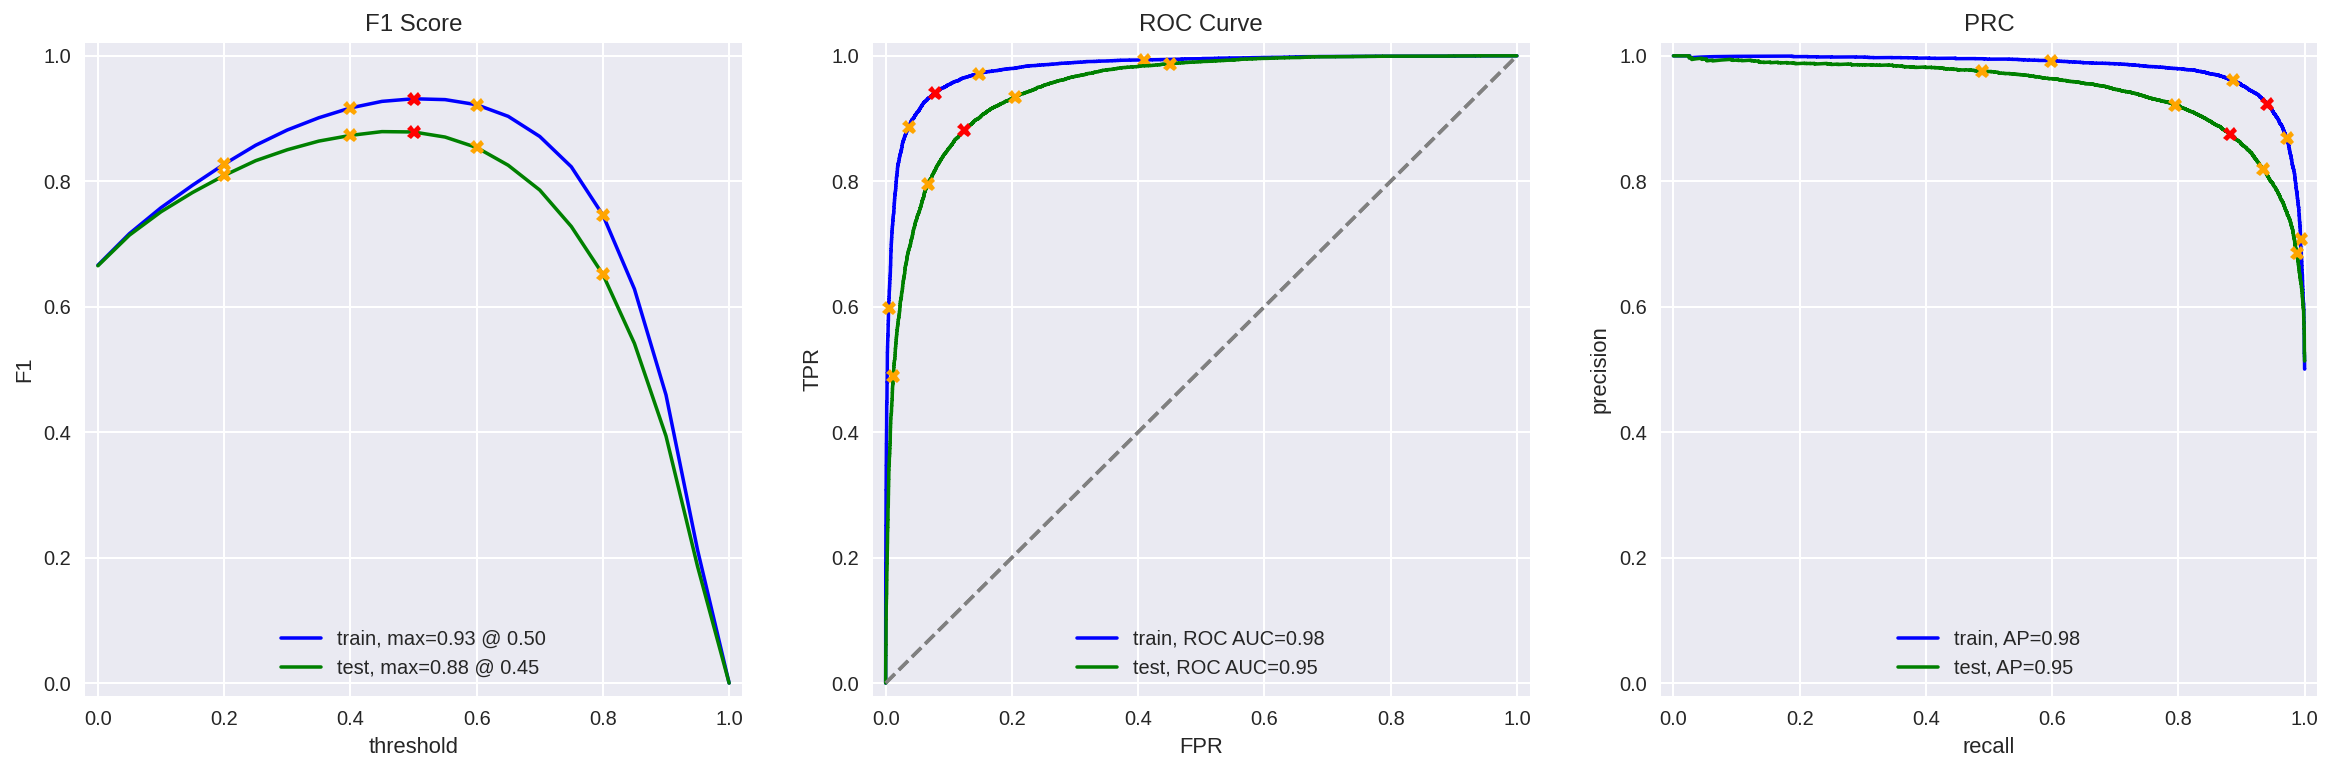

In [39]:
evaluate_model(model_2, spacy_train_features, train_target, spacy_test_features, test_target)

### Model 3 - spaCy, TF-IDF and LGBMClassifier

Because this model is also using spaCy we can use the same features and test data as the previous model.

In [41]:
model_3 = LGBMClassifier(random_state = 12345)
model_3.fit(spacy_train_features, train_target)

LGBMClassifier(random_state=12345)

In [42]:
predictions_3 = model_3.predict(spacy_test_features)
print('Accuracy :', accuracy_score(test_target, predictions_3))

Accuracy : 0.8580291505545404


          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


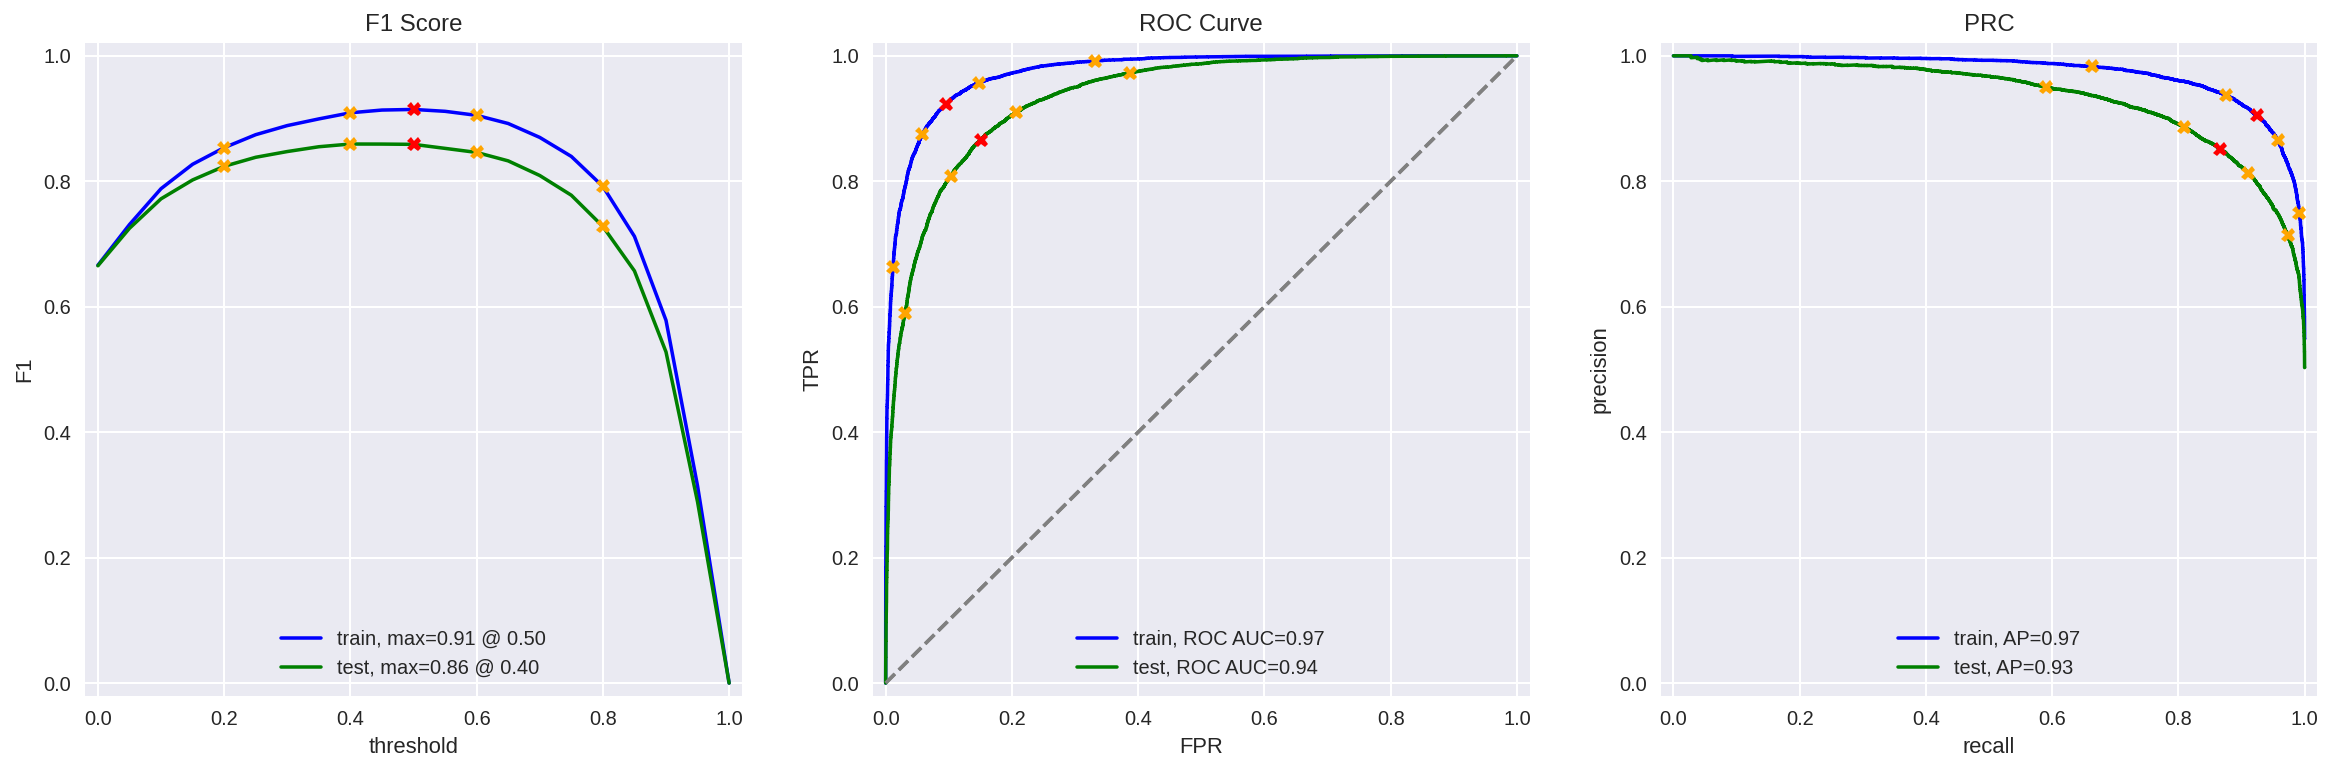

In [43]:
evaluate_model(model_3, spacy_train_features, train_target, spacy_test_features, test_target)

###  Model 9 - BERT

In [45]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=25, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    sample_size = 750 # define a sample size to just do a BERT test on a smaller section of the data set

    # text to padded ids of tokens along with their attention masks
    
    for text in df_reviews.iloc[:sample_size]['review']:
        ids = tokenizer.encode(text.lower(), add_special_tokens = True, truncation = True, max_length = max_length)
        padded_ids = np.array(ids + [0] * (max_length - len(ids)))
        ids_list.append(padded_ids)
        
        attention_mask = np.where(padded_ids != 0, 1, 0)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

A quick note that the ability to tweak the BERT model is limited since oftentimes running it with certain parameters has caused the kernel to fail.

In [47]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device= 'cpu')

Using the cpu device.


  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_287/2298462202.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [48]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(750, 768)
(23796,)


In [51]:
max_sample_size = 750
features_bert = train_features_9
target_bert = df_reviews.iloc[:max_sample_size]['pos']

print(features_bert.shape)
print(target_bert.shape)

(750, 768)
(750,)


In [52]:
features_bert_train, features_bert_test, target_bert_train, target_bert_test = train_test_split(features_bert, 
                                                                                                target_bert, 
                                                                                                test_size = 0.5, 
                                                                                                random_state = 12345) 
print(features_bert_train.shape)
print(features_bert_test.shape)
print(target_bert_train.shape)
print(target_bert_test.shape)

(375, 768)
(375, 768)
(375,)
(375,)


In [53]:
model_9 = LogisticRegression(solver='lbfgs')
model_9.fit(features_bert_train, target_bert_train)

LogisticRegression()

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [54]:
predictions_9 = model_9.predict(features_bert_test)
print('Accuracy :', accuracy_score(target_bert_test, predictions_9))

Accuracy : 0.8373333333333334


          train  test
Accuracy    1.0  0.84
F1          1.0  0.86
APS         1.0  0.93
ROC AUC     1.0  0.91


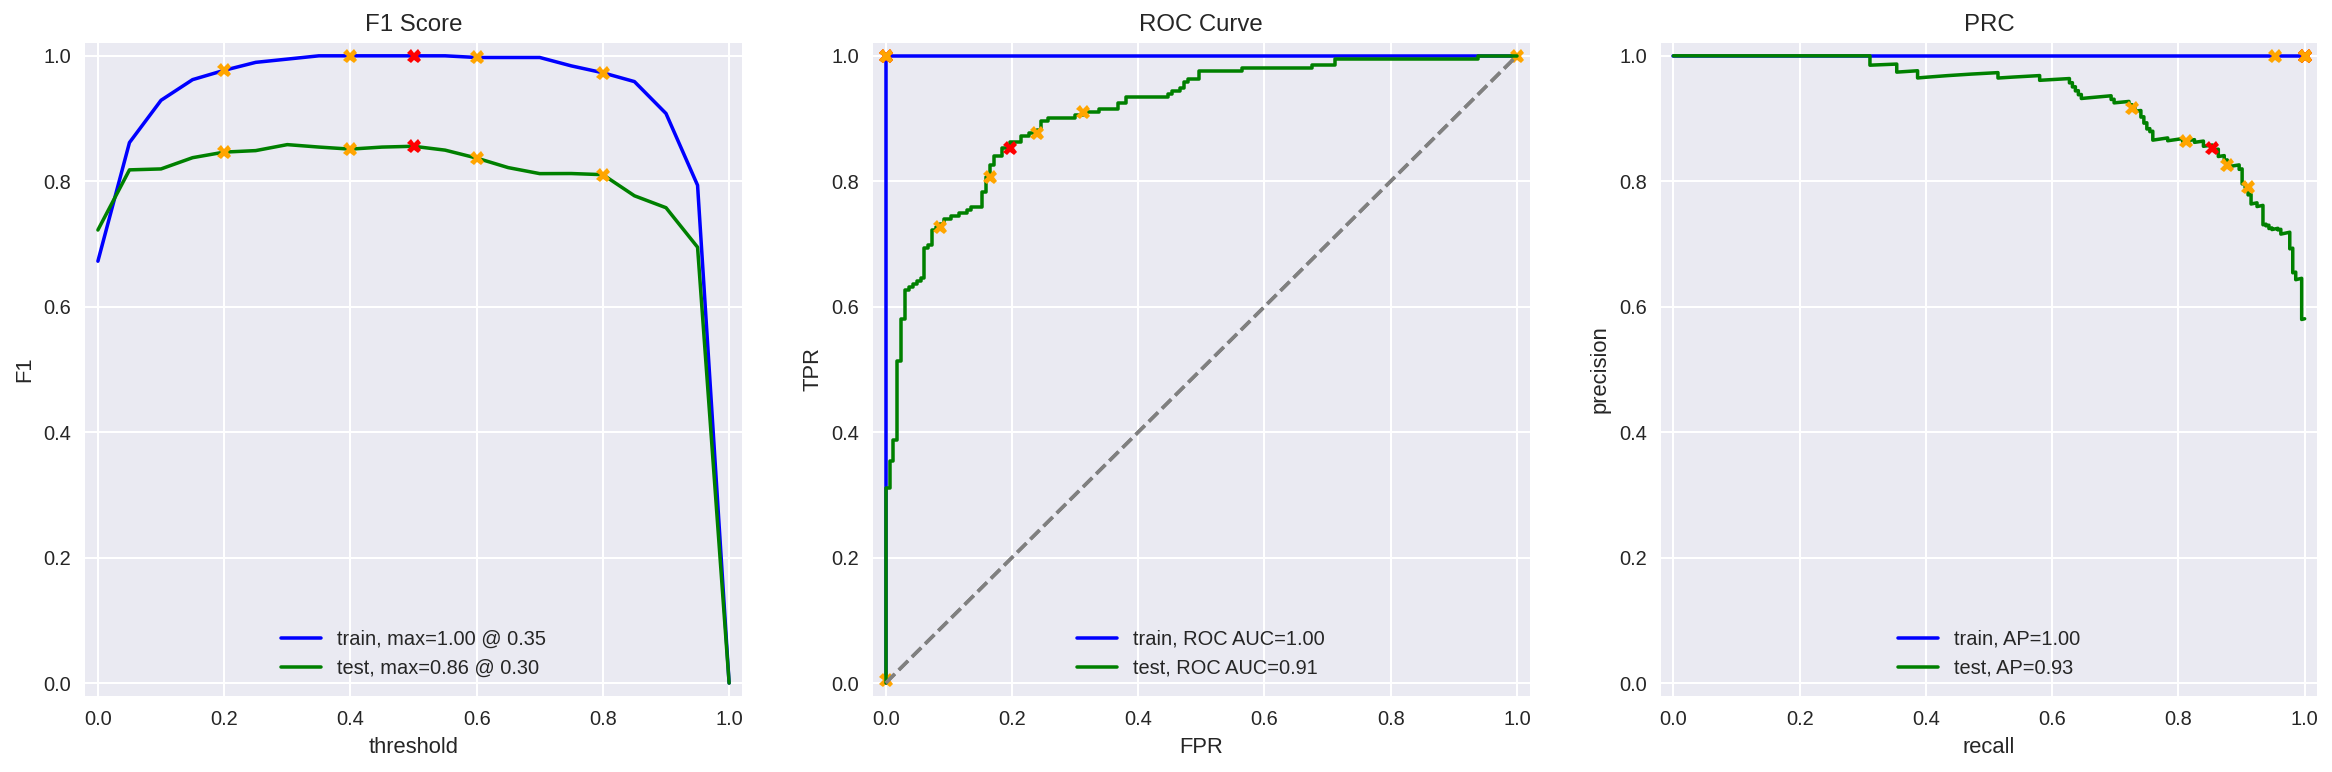

In [55]:
evaluate_model(model_9, features_bert_train, target_bert_train, features_bert_test, target_bert_test)

Overall, it appears that the most of our models are fairly comparable but that the BERT model is a little less accurate against our test set. However, this might not hold true for future reviews. We could attempt to adjust our model parameters to get a better result but at present they are all meeting our standards. Before trying to move to a phase of improving the model, it would be a good idea to get an understanding on our models by manually creating reviews to test against.

## My Reviews

In order to test and see how well our models work, we can manually create some reviews with the intent of capturing a negative or positive sentiment and test against those.

In [56]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    
    # for some additional reviews to add, some clearly positive and negative ones will be added
    # in addition to some ones with rather vague wording, and some that are either mixed or that might trick the model
    
    'Very rough around the edges. Had promise but failed to deliver.',
    'It\'s obscure, but it really should be getting more attention!',
    'If you like the characters, you\'ll enjoy this show. It is not as story-focused if that is what you are looing for.',
    'I could barely manage to sit through the first few episodes.',
    'The definition of a \'slow burn\'. It takes some time to get going, but trust me - it\'s worth it. Unfortunately, I can\'t talk much about the specifics without spoiling the plot.',
    'I would rather pretend that this sequel is non-canon. Some people are fine with it, but it does some things with my favorite parts of the series that change them.',
    'Fine on an initial watch but if you rewatch it then the cracks really start to show.',
    'It\'s really funny, with some heartwarming and thought-provoking parts as well.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lower)
my_reviews['review_norm'] = my_reviews['review_norm'].apply(clear_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...
8,Very rough around the edges. Had promise but f...,very rough around the edges had promise but fa...
9,"It's obscure, but it really should be getting ...",it s obscure but it really should be getting m...


### Model 1

In [57]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.28:  very rough around the edges had promise but failed to deliver
0.52:  it s obscure but it really should be getting more attention
0.74:  if you like the characters you ll enjoy this show it is not as story focused if that is what you are
0.26:  i could barely manage to sit through the first few episo

### Model 2

In [59]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.48:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didn t expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.21:  very rough around the edges had promise but failed to deliver
0.61:  it s obscure but it really should be getting more attention
0.92:  if you like the characters you ll enjoy this show it is not as story focused if that is what you are
0.25:  i could barely manage to sit through the first few episo

### Model 3

In [60]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = count_tf_idf_2
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  i did not simply like it not my kind of movie
0.37:  well i was bored and felt asleep in the middle of the movie
0.58:  i was really fascinated with the movie
0.34:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.65:  i didn t expect the reboot to be so good writers really cared about the source material
0.70:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.38:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.78:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.30:  very rough around the edges had promise but failed to deliver
0.61:  it s obscure but it really should be getting more attention
0.80:  if you like the characters you ll enjoy this show it is not as story focused if that is what you are
0.46:  i could barely manage to sit through the first few episo

### Model 9

In [61]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  i did not simply like it not my kind of movie
0.01:  well i was bored and felt asleep in the middle of the movie
0.78:  i was really fascinated with the movie
0.96:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.86:  i didn t expect the reboot to be so good writers really cared about the source material
1.00:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.98:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.69:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.28:  very rough around the edges had promise but failed to deliver
0.69:  it s obscure but it really should be getting more attention
0.87:  if you like the characters you ll enjoy this show it is not as story focused if that is what you are
0.03:  i could barely manage to sit through the first few episo

## Conclusions

To begin with, we checked our data and the EDA of reviews based on the years given. We achieved the threshold F1 score across all our models. Model 1 had the overall best performance accounting for both the training and test set interactions, but model 2 had almost identical performance.

When we tested against our own smaller set of reviews, the relative accuracy did go down, especially with some of the reviews that were written in a way that might confuse the model (entires 12 and 13) by including some negative language in a positive review or some positive language in a negative review. None of the models correctly identified 12 as a positive review, and only the BERT model could identify 13 as a negative review while also having rather spotty accuracy for other clearly defined reviews.

The BERT model does seem like it has the greatest potential, but it is a bit hardware dependent. As it is, Model 1 or 2 is the best option. Model 2 performed slightly better against the my_reviews data set, getting one more correctly identified positive review than model 1.

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions